# Post-Processing Verification
We have a model with `Dice ~0.42` and `Merge 1.0` (Bridged).
This notebook tests if `src.post.clean.clean_prediction` can break the bridges.

In [1]:
import torch
import numpy as np
import tifffile
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('src')

from models.unet3d import AttentionUNet3D
from utils.inference import predict_sliding_window
from utils.topology import calculate_merge_score, calculate_dice
from post.clean import clean_prediction

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [2]:
# Load Model
model = AttentionUNet3D(attention=True, depth=3, pool_kernel_size=(1, 2, 2)).to(device)
ckpt = Path('models/best_topology_cldice.pth')
model.load_state_dict(torch.load(ckpt))
model.eval()
print("Model Loaded.")

Model Loaded.


In [3]:
# Load Validation Volume (Just one)
val_vol_path = sorted(list(Path('data/train_images').glob('*.tif')))[-1]
val_lbl_path = Path('data/train_labels') / val_vol_path.name

print(f"Testing on {val_vol_path.name}")

gt_vol = tifffile.imread(val_lbl_path)
gt_vol = (gt_vol == 1).astype(np.float32)

inp_vol = tifffile.imread(val_vol_path).astype(np.float32)
if inp_vol.max() <= 255:
    inp_vol /= 255.0
else:
    inp_vol = (inp_vol - inp_vol.min()) / (inp_vol.max() - inp_vol.min() + 1e-6)

with torch.no_grad():
    pred_probs = predict_sliding_window(model, inp_vol, patch_size=(32, 128, 128), overlap=0.25, device=device)
    
pred_probs = pred_probs[:gt_vol.shape[0], :gt_vol.shape[1], :gt_vol.shape[2]]

Testing on 992852942.tif


In [4]:
# Baseline Metrics (Raw Threshold)
raw_thresh = 0.3
raw_merge = calculate_merge_score(pred_probs, gt_vol, threshold=raw_thresh)
raw_dice = calculate_dice(torch.from_numpy(pred_probs), torch.from_numpy(gt_vol), threshold=raw_thresh)
print(f"Raw (Thresh {raw_thresh}): Merge={raw_merge}, Dice={raw_dice:.4f}")

Raw (Thresh 0.3): Merge=2, Dice=0.2802


In [5]:
# Apply Cleaning
cleaned_mask = clean_prediction(
    pred_probs, 
    threshold=0.3, 
    min_component_size=1000, 
    bridge_break_iter=1
)

# Recalculate Logic to use Mask instead of Probs for Merge Score util (hack)
# The util expects probs, so we just pass the binary mask as float 0.0/1.0 and thresh 0.5
clean_probs = cleaned_mask.astype(np.float32)

clean_merge = calculate_merge_score(clean_probs, gt_vol, threshold=0.5)
clean_dice = calculate_dice(torch.from_numpy(clean_probs), torch.from_numpy(gt_vol), threshold=0.5)

print(f"Cleaned: Merge={clean_merge}, Dice={clean_dice:.4f}")

Cleaned: Merge=4, Dice=0.2776


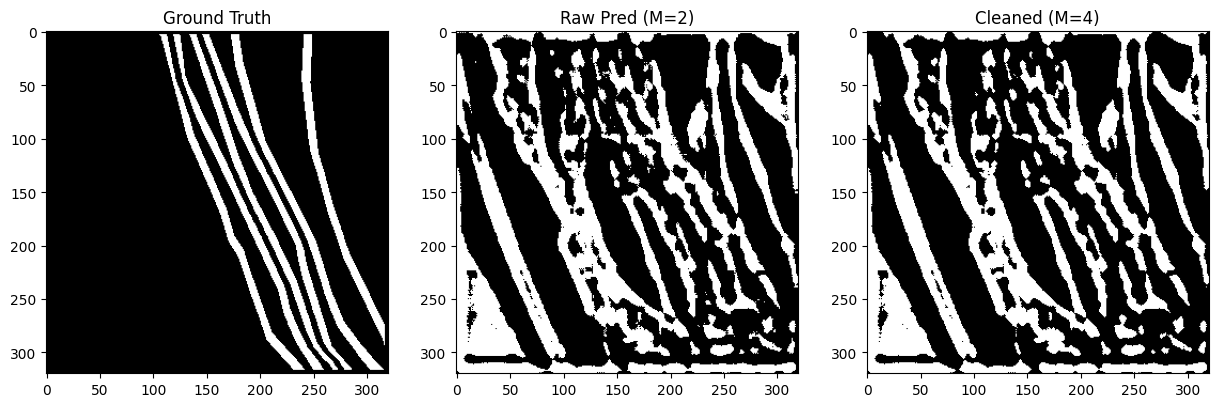

In [6]:
# Visualize
mid_z = gt_vol.shape[0] // 2

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(gt_vol[mid_z], cmap='gray')
ax[0].set_title("Ground Truth")

ax[1].imshow(pred_probs[mid_z] > 0.3, cmap='gray')
ax[1].set_title(f"Raw Pred (M={raw_merge})")

ax[2].imshow(cleaned_mask[mid_z], cmap='gray')
ax[2].set_title(f"Cleaned (M={clean_merge})")
plt.show()